# 3- Creation of the RL model


Hello everyone, in this part we are going to use the custom gym enviroment and then we setup the RL model.

## Step 1 - Load gym model

First we will consider the gym local enviroment BasicEnv13


In [13]:
import pandas as pd

In [14]:
df= pd.read_csv("test.csv")

In [15]:
df.head(5)

,x_coord,y_coord,building,floor,seat_id,island,project,energy_consumption,emp_project,emp_energy_consumption,occupied
0,18.0,694.0,bari,floor_1,0,7,1,3,5,1,0
1,521.0,311.0,bari,floor_1,1,3,5,5,5,1,1
2,188.0,298.0,bari,floor_1,2,9,2,3,4,1,0
3,557.0,294.0,bari,floor_1,3,3,1,2,1,3,0
4,423.0,290.0,bari,floor_1,4,2,3,2,2,1,0


In [16]:
df.shape

(20, 11)

In [17]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import pygame
from pygame import display
from pygame.surfarray import array3d
import random
import pandas as pd
from PIL import Image
import time
training=False

df= pd.read_csv("test.csv")
feature1=df['island'].max()
feature2=df['project'].max()
feature3=df['energy_consumption'].max()
feature4=df['emp_project'].max()
feature5=df['emp_energy_consumption'].max()
feature6=df['occupied'].max()

max_colors=df['island'].nunique()
low_x=int(df['x_coord'].min())
high_x=int(df['x_coord'].max())
low_y=int(df['y_coord'].min())
high_y=int(df['y_coord'].max())
possible_clicks=df.shape[0]
pos_x=possible_clicks
pos_y=possible_clicks
max_sit=possible_clicks

# get image
filepath = "bg.jpg"
img_bg = Image.open(filepath)
# get width and height
width = img_bg.width
height = img_bg.height
  
font_color=(0,50,250)
WHITE = pygame.Color(255, 255, 255)
RED = (200,0,0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)

#Load images
#To the image we assing a kind of gym object
worker_pos=[25,25]
#Target image and position
position_coordinates=[(50,50),
                      (100,50),
                      (150,50)]

target_rects={}
target_images={}
counts = df.groupby(['island'])['island'].count()
reward_dict=counts.to_dict()

def convert_colormap_to_hex(cmap, x, vmin=0, vmax=1):
    """
    Example::
        >>> seaborn.palplot(seaborn.color_palette("RdBu_r", 7))
        >>> colorMapRGB = seaborn.color_palette("RdBu_r", 61)
        >>> colormap = seaborn.blend_palette(colorMapRGB, as_cmap=True, input='rgb')
        >>> [convert_colormap_to_hex(colormap, x, vmin=-2, vmax=2) for x in range(-2, 3)]
        ['#09386d', '#72b1d3', '#f7f6f5', '#e7866a', '#730421']
    """
    norm = colors.Normalize(vmin, vmax)
    color_rgb = plt.cm.get_cmap(cmap)(norm(x))
    color_hex = colors.rgb2hex(color_rgb)
    return color_hex

import  seaborn
from matplotlib import colors
from PIL import ImageColor
colorMapRGB = seaborn.color_palette("RdBu_r", max_colors)
colormap = seaborn.blend_palette(colorMapRGB, as_cmap=True, input='rgb')
cmap_list=[convert_colormap_to_hex(colormap, x, vmin=-int(max_colors/2)-1, vmax=int(max_colors/2)+1) for x in range(-int(max_colors/2)-1, int(max_colors/2)+1)]


class MyEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self):
        # There are two actions, first will get reward of 1, second reward of -1. 
        self.action_space = spaces.Discrete(possible_clicks)
        self.observation_space = gym.spaces.Dict(
     {"feature1": gym.spaces.Box(low=0, high=feature1, shape=(1,), dtype=np.uint8),
     "y_position": gym.spaces.Box(low=low_y, high=high_y, shape=(1,), dtype=np.uint8),
     "x_position": gym.spaces.Box(low=low_x, high=high_x, shape=(1,), dtype=np.uint8)
     }
        )
        # We inizialize the display
        self.frame_size_x = width # high_x
        self.frame_size_y = height# high_y
        self.game_window = pygame.display.set_mode((self.frame_size_x, self.frame_size_y))  
        self.reset()
  
    def reset(self):
        self.game_window.fill(WHITE)
        self.state = None
        self.steps = 0
        self.worker_pos=[25,25] 
        self.score = 0
        self.steps = 0
        action=(0,0)
        img = array3d(display.get_surface())
        img = np.swapaxes(img, 0, 1)
        self.STEP_LIMIT = 1000
        #To the image we assing a kind of gym object
        self.worker_rect=pygame.draw.circle(self.game_window,BLUE,(self.worker_pos[0], self.worker_pos[1]),6) # DRAW CIRCLE
        # Moreover we add a position in the screen display
        self.target_rects={} 
        n_space=df.shape[0]
        for num in range(n_space):
            targets=int(df['x_coord'][num]), int(df['y_coord'][num])
            numero_cluster=df['island'][num]
            cmap_color=cmap_list[numero_cluster-1]
            target_images[num] = pygame.draw.circle(self.game_window,cmap_color,(targets[0], targets[1]),6) # DRAW CIRCLE
            self.target_rects[num] = target_images[num]
            #print('Initial positions',targets)
            self.target_rects[num].center = targets
        # Adding text
        pygame.init()
        self.font_color=(0,50,250)                                       # Step 1  Color RGB code
        self.font_obj=pygame.font.Font("C:\Windows\Fonts\Arial.ttf",20)  # Step 2  Select the font type
        # Render the objects
        self.text_obj=self.font_obj.render("Reward:",True,self.font_color) # Step 3  Creation of object text        
        #state, reward, done, info = self.step(action) 
        return img        
        #return state, reward, done, info
        
    def reward_value(self,worker,target,num):
        
        #print(Reward check: )
        #Check for collision between two rects            
        if worker.colliderect(target):
            '''
            Reward 1 - The more dense is the cluster more reward  
            Gives the value of the island   number of seats
                0    2
                1    4
                2    4
                3    4
                4    1
            '''
            number_island=df['island'].iloc[num]
            reward1=reward_dict[number_island]

            '''
            Reward 2 - Check if is occupied
                0 - occupied
                1 - free
            '''
            is_occupied=df['occupied'].iloc[num]
           
            '''
            Reward 3 - More neighbors more reward
            '''
            reward3=len(df[(df['island']==number_island) & (df['occupied']==0 )])
            reward=(reward1+reward3)*is_occupied
            
            if is_occupied == 0:
                if training:  print('is_occupied',is_occupied)
            else:
                if training:  print('reward',reward)
            
            return reward
        
        else:
            
            reward = 0
            return reward
            
    def step(self, action):
        reward = 0
        total_reward=0
        # Check if variable is  tuple
        # using type()
        #res = type(action) is tuple       
        # Inside gym the test need tuples and not int
        
        if (type(action) == int) or (isinstance(action, np.int64)) :
            action_n=int(action)
            if training: print('action_n',action_n)
            action=int(df['x_coord'][action_n]), int(df['y_coord'][action_n])
        
        self.worker_pos = action
        if training: print('The action is inside step:', action, type(action))
        rewards=[]
        # We update the state of worker_rect and image
        self.update_game_state() 
        
        
        # regardless of the action, game is done after a single step
        if action != None:
            if training:  print("The action is :", action)  
            n_space=df.shape[0]
            for num in range(n_space):
                reward = self.reward_value(self.worker_rect,self.target_rects[num],num)
                #print('num',num)

                if reward !=0:
        
                    #print("The worker rect is :",self.worker_rect)
                    #print("The target rect is :",self.target_rects[num] ) 
                    rewards.append(reward)
                    #print("rewards",rewards)
                    
        if len(rewards) < 1:
            reward=0
        else:
            reward=rewards[0]

        if training == False:
            # Render the objects
            self.text_obj=self.font_obj.render("Reward :" + str(reward),True,self.font_color) # Step 3  Creation of object text
            #Display text
            self.game_window.blit(self.text_obj,(300,0))         
                          
        img = self.get_image_array_from_game()
        
        info = {}
        reward_tmp, done = self.game_over(reward)
        #done = True ### Testing without Accumulative
        total_reward=total_reward+reward_tmp ### Accumulative
        
        if training:  print('reward: {}, done: {}, info: {}, step: {}'.format(reward, done, info,self.steps))
        self.steps += 1
        return img, total_reward, done, info

    
    def worker_step(self,event):   
        '''
        Takes human keyboard event and then returns it as an action string
        '''
        action = None
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()
            
        #Move based on mouse clicks
        if event.type == pygame.MOUSEBUTTONDOWN:
            #print(event)
            mouse_x = event.pos[0]
            mouse_y = event.pos[1]

            #'CLICK'
            action = mouse_x, mouse_y
        
        #Drag the object when the mouse button is clicked
        if event.type == pygame.MOUSEMOTION and event.buttons[0] == 1:
            #print(event)
            mouse_x = event.pos[0]
            mouse_y = event.pos[1]
    
            #'CLICK'
            action = mouse_x, mouse_y
        
        elif event.type == pygame.KEYDOWN:
        
            # Esc -> Create event to quit the game
            if event.key == pygame.K_ESCAPE:
                pygame.event.post(pygame.event.Event(pygame.QUIT))                       
        return action    
    
    def update_game_state(self):
        #We fill the screen to white
        if training != True:
            self.game_window.fill(WHITE)
        else:    
            bg = pygame.image.load("bg.jpg")
            #Give a background color to the display
            self.game_window.blit(bg, (0, 0))
        # -------------WORKER--------------
        
        #if type(self.worker_pos) == int:
        #    action_n=self.worker_pos
        #    print('action_n in update is:',action_n)
        #    action=int(df['x_coord'][action_n]), int(df['y_coord'][action_n])
        #    self.worker_pos=action    
        
        if training: 
            print('self.worker_pos:',self.worker_pos)
            print('worker_pos',self.worker_pos[0],self.worker_pos[1])
        
        self.worker_rect.x=self.worker_pos[0]
        self.worker_rect.y=self.worker_pos[1]
        #Draw rectangles to represent the rect's of each object
        self.worker_rect=pygame.draw.circle(self.game_window,BLUE,(self.worker_rect.x,self.worker_rect.y),6) # DRAW CIRCLE
        
        #-------------- Multiple points TARGETS------------------
        n_space=df.shape[0]
        for num in range(n_space):
            numero_cluster=df['island'][num]
            cmap_color=cmap_list[numero_cluster-1]
            occupied=df['occupied'][num]
            if occupied == 0:
                color=RED
            else:
                color=GREEN
            pygame.draw.circle(self.game_window,color,(self.target_rects[num].x,self.target_rects[num].y),6) # DRAW CIRCLE
            
    def get_image_array_from_game(self):
        img = array3d(display.get_surface())
        #Preprocessing of channels ( needed for tensorflow)
        img = np.swapaxes(img, 0, 1)
        return img    
   
    def render(self, mode='human'):
        if mode == "human":
            display.update()        
    def close(self):
        pass
    
    def game_over(self, reward):
        if (reward == 0) or ( self.steps >= 20): 
            
            #self.end_game()
            
            return -1, True

        return reward, False
    
    
    def end_game(self):

        message = pygame.font.SysFont('arial', 20)
        message_surface = message.render('Ciao! Perché non ti siedi qua?' +' '+str("s"), True, RED)
        message_rect = message_surface.get_rect()
        message_rect.midtop = (self.frame_size_x / 2, self.frame_size_y / 4)
        self.game_window.fill(BLACK)
        self.game_window.blit(message_surface, message_rect)
        pygame.display.flip()
        #time.sleep(20)
        pygame.quit()
        sys.exit()    

In [15]:
import sys
env = MyEnv()
env.reset()
# This is technically a FPS Refresh rate
FPS = 10
# FPS (frames per second) controller
fps_controller = pygame.time.Clock()
# Checks for errors encountered
check_errors = pygame.init()
# Initialise game window
pygame.display.set_caption('Testing Game') 
#The main game loop
running = True
while running:
    # Check Input from Human Step 
    for event in pygame.event.get():
        action = env.worker_step(event)    
        if event.type == pygame.QUIT:
            running = False
        pygame.display.update() 
        if action != None :# and reward!=0:
            state, reward, done, info = env.step(action)
            print("Reward = {} with action = {}".format(reward,action))
            # Refresh game screen    
    # Refresh rate
    fps_controller.tick(FPS)
    img = array3d(env.game_window)

Reward = -1 with action = (284, 228)
Reward = -1 with action = (302, 157)
Reward = -1 with action = (79, 161)
Reward = -1 with action = (222, 269)


SystemExit: 

C:\Users\RMAGANAV\Anaconda3\envs\rl2\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Step 2 - Test the gym model
In this part we want to test the local gym class.


In [4]:
# method 1 - use local test class
env = MyEnv()
env.render("human")

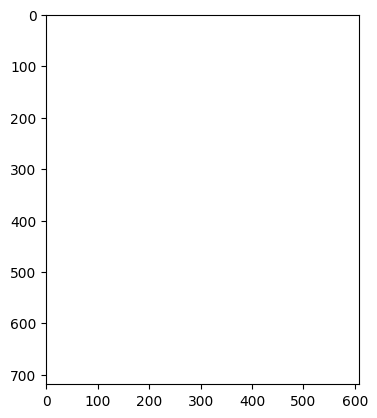

In [5]:
plt.figure()
plt.imshow(env.reset())

Reward = 5 with action = 6


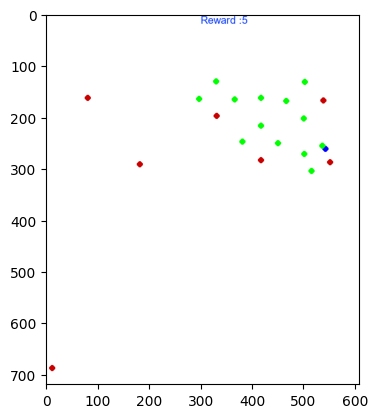

In [6]:
action_n = env.action_space.sample()
state, reward, done, info = env.step(action_n)
print("Reward = {} with action = {}".format(reward,action_n))
#print(state)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(state)

action_n 0
(18, 694)
Reward = -1 with action = (18, 694)


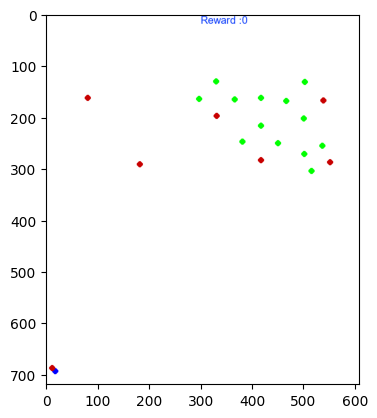

In [18]:
action_n = env.action_space.sample()
print('action_n',action_n)
action=int(df['x_coord'][action_n]), int(df['y_coord'][action_n])
print(action)
state, reward, done, info = env.step(action)
print("Reward = {} with action = {}".format(reward,action))
#print(state)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(state)

In [19]:
state.shape

(719, 609, 3)

In [20]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 3
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(3, 84, 84)

In [21]:
from PIL import Image  # To transform the image in the Processor
import numpy as np
import gym
# Convolutional Backbone Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam

# Keras-RL
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [265]:
nb_actions = env.action_space.n

In [266]:
nb_actions

20

In [267]:
IMG_SHAPE = (84, 84)
WINDOW_LENGTH = 3

In [268]:
class ImageProcessor(Processor):
    def process_observation(self, observation):
        # First convert the numpy array to a PIL Image
        img = Image.fromarray(observation)
        # Then resize the image
        img = img.resize(IMG_SHAPE)
        # And convert it to grayscale  (The L stands for luminance)
        img = img.convert("L")
        # Convert the image back to a numpy array and finally return the image
        img = np.array(img)
        return img.astype('uint8')  # saves storage in experience memory
    
    def process_state_batch(self, batch):
        # We divide the observations by 255 to compress it into the intervall [0, 1].
        # This supports the training of the network
        # We perform this operation here to save memory.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [269]:
class ImageProcessorFix(Processor):
    def process_observation(self,observation):
        if type(observation) == type(None):
            whiteFrame= 255 * np.ones((640,480,3), np.uint8)
            observation=whiteFrame
        # First convert the numpy array to a PIL Image
        img = Image.fromarray(observation)
        # Then resize the image
        img = img.resize(IMG_SHAPE)
        # And convert it to grayscale  (The L stands for luminance)
        #img = img.convert("L")
        # Convert the image back to a numpy array and finally return the image
        img = np.array(img)
        return img.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We divide the observations by 255 to compress it into the intervall [0, 1].
        # This supports the training of the network
        # We perform this operation here to save memory.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

## Model Creation

**NOTE: Depending on your custom environment, this model will vary greatly, try reading papers that are solving similar problems to your own!**

In [270]:
input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])
input_shape

(3, 84, 84)

In [271]:
model = Sequential()
model.add(Permute((2, 3, 1), input_shape=input_shape))
model.add(Convolution2D(32, (8, 8), strides=(4, 4),kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (4, 4), strides=(2, 2), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_7 (Permute)         (None, 84, 84, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 20, 20, 32)        6176      
                                                                 
 activation_35 (Activation)  (None, 20, 20, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 9, 9, 64)          32832     
                                                                 
 activation_36 (Activation)  (None, 9, 9, 64)          0         
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 activation_37 (Activation)  (None, 7, 7, 64)         

In [272]:
model2=False
if model2:
    from keras.models import Sequential
    from keras.layers import Dense, Conv2D, Flatten
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))  # (28,28,1)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(nb_actions, activation='softmax'))
    print(model.summary())

----
## Creating the Agent

In [273]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

In [274]:
processor = ImageProcessor()

In [287]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=10000)

In [288]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=500, gamma=.99, target_model_update=1000,
              train_interval=4, delta_clip=1)

In [289]:
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

In [290]:
weights_filename = 'test_dqn_worker_weights.h5f'
checkpoint_weights_filename = 'test_dqn_' + "worker" + '_weights_{step}.h5f'
checkpoint_callback = ModelIntervalCheckpoint(checkpoint_weights_filename, interval=100000)

In [291]:
#nb_steps=1500000

In [299]:
history=dqn.fit(env, nb_steps=500, callbacks=[checkpoint_callback], log_interval=1000, visualize=False)

Training for 500 steps ...
Interval 1 (0 steps performed)
 500/1000 [==============>...............] - ETA: 13s - reward: 0.3440done, took 13.808 seconds


In [300]:
print(history)

In [301]:
# list all data in history
print(history.history.keys())
#['accuracy', 'loss', 'val_accuracy', 'val_loss']

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


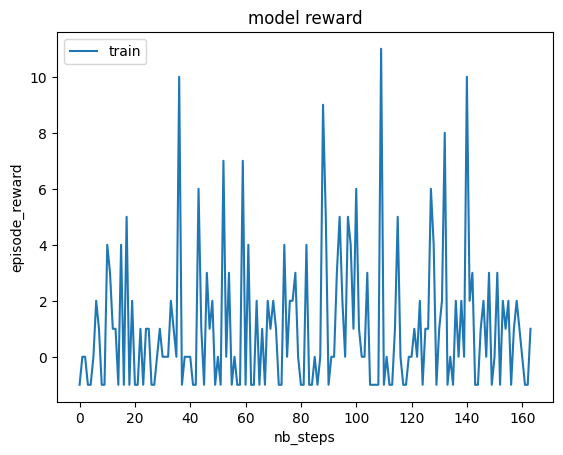

In [302]:
# summarize history for accuracy
plt.plot(history.history['episode_reward'])
#plt.plot(history.history['nb_episode_steps'])
plt.title('model reward')
plt.ylabel('episode_reward')
plt.xlabel('nb_steps')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [303]:
# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

In [304]:
print('Final final weights were stored in', weights_filename)

Final final weights were stored in test_dqn_worker_weights.h5f


In [305]:
# After training is done, we save the final weights.
dqn.load_weights(weights_filename)

In [306]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=1, visualize=False) 

Testing for 1 episodes ...
Episode 1: reward: 19.000, steps: 21


 # Example 2

https://www.programcreek.com/python/?code=PacktPublishing%2FDeep-Learning-Quick-Reference%2FDeep-Learning-Quick-Reference-master%2FChapter12%2Fdqn_breakout_test.py

In [12]:
import keras.backend as K

In [308]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 3

In [309]:
np.random.seed(42)
env.seed(42)
num_actions = env.action_space.n

In [310]:
num_actions

20

In [311]:
def build_model(state_size, num_actions):
    input_shape = (3,) + state_size
    model = Sequential()
    model.add(Permute((2, 3, 1), input_shape=input_shape))

    '''
    if K.image_dim_ordering() == 'tf':
        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
    elif K.image_dim_ordering() == 'th':
        # (channels, width, height)
        model.add(Permute((1, 2, 3), input_shape=input_shape))
    else:
        raise RuntimeError('Unknown image_dim_ordering.')
    '''    
    model.add(Convolution2D(32, (8, 8), strides=(4, 4),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (4, 4), strides=(2, 2),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, (3, 3), strides=(1, 1),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_actions))
    model.add(Activation('linear'))
    print(model.summary())
    return model

In [312]:
model = build_model(INPUT_SHAPE, num_actions)
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_8 (Permute)         (None, 84, 84, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 20, 20, 32)        6176      
                                                                 
 activation_40 (Activation)  (None, 20, 20, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 9, 9, 64)          32832     
                                                                 
 activation_41 (Activation)  (None, 9, 9, 64)          0         
                                                                 
 conv2d_26 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 activation_42 (Activation)  (None, 7, 7, 64)         

In [313]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        
       # if type(observation) == type(None):
       #     whiteFrame= 255 * np.ones((640,480,3), np.uint8)
       #     observation=whiteFrame
            
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize((84, 84), Image.ANTIALIAS).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == (84, 84)
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch
    
    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


In [314]:
processor = AtariProcessor()

In [315]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000) #1000000)

In [316]:
def build_callbacks(env_name):
    checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(env_name)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
    callbacks += [FileLogger(log_filename, interval=100)]
    return callbacks

In [317]:
dqn = DQNAgent(model=model, nb_actions=num_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)

In [318]:
ENV_NAME = 'Test-RL-v2'

In [319]:
dqn.compile(Adam(lr=.00025), metrics=['mae'])
callbacks = build_callbacks(ENV_NAME)

In [321]:
history=dqn.fit(env, nb_steps=500, callbacks=callbacks, log_interval=100000, visualize=False)

Training for 500 steps ...
Interval 1 (0 steps performed)
   499/100000 [..............................] - ETA: 53:26 - reward: 0.0461done, took 16.162 seconds


In [322]:
# list all data in history
print(history.history.keys())
#['accuracy', 'loss', 'val_accuracy', 'val_loss']

dict_keys(['episode_reward', 'nb_episode_steps', 'nb_steps'])


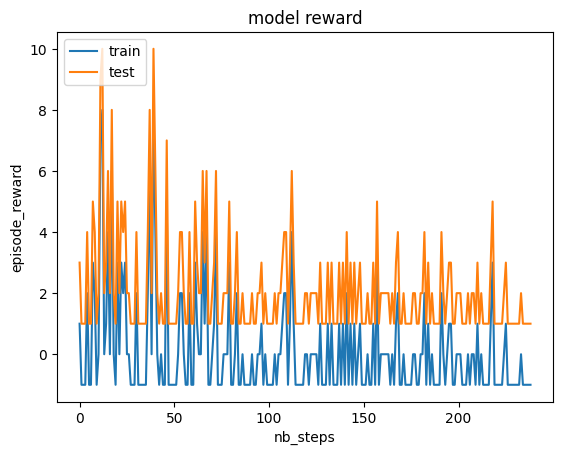

In [323]:
# summarize history for accuracy
plt.plot(history.history['episode_reward'])
plt.plot(history.history['nb_episode_steps'])
plt.title('model reward')
plt.ylabel('episode_reward')
plt.xlabel('nb_steps')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [324]:
# After training is done, we save the final weights.
#dqn.load_weights('Test-RL-v2_1750000.h5f')

In [325]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True) 

Testing for 5 episodes ...
Episode 1: reward: -1.000, steps: 1
Episode 2: reward: -1.000, steps: 1
Episode 3: reward: -1.000, steps: 1
Episode 4: reward: -1.000, steps: 1
Episode 5: reward: -1.000, steps: 1


# Example 3

In [18]:
import gym, ray
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPOConfig

In [22]:
help(ppo.PPO)

Help on class PPO in module ray.rllib.algorithms.ppo.ppo:

class PPO(ray.rllib.algorithms.algorithm.Algorithm)
 |  PPO(config: Union[ray.rllib.algorithms.algorithm_config.AlgorithmConfig, NoneType] = None, env=None, logger_creator: Union[Callable[[], ray.tune.logger.logger.Logger], NoneType] = None, **kwargs)
 |  
 |  An RLlib algorithm responsible for optimizing one or more Policies.
 |  
 |  Algorithms contain a WorkerSet under `self.workers`. A WorkerSet is
 |  normally composed of a single local worker
 |  (self.workers.local_worker()), used to compute and apply learning updates,
 |  and optionally one or more remote workers used to generate environment
 |  samples in parallel.
 |  WorkerSet is fault tolerant and elastic. It tracks health states for all
 |  the managed remote worker actors. As a result, Algorithm should never
 |  access the underlying actor handles directly. Instead, always access them
 |  via all the foreach APIs with assigned IDs of the underlying workers.
 |  
 

In [20]:
from ray.rllib.algorithms.bc import BCConfig
from ray import tune
from env import MyEnv

In [21]:
ray.shutdown()
ray.init()
#config = BCConfig()
# Print out some default values.
#print(config.beta) 
config = PPOConfig().rollouts(horizon=200) 

2023-01-16 17:12:02,406	INFO worker.py:1538 -- Started a local Ray instance.


In [4]:
algo = ppo.PPO(env=MyEnv, config={
    "env_config": {},  # config to pass to env class
})

2023-01-16 14:14:01,153	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'env.MyEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'env.MyEnv'>').build()` instead. This will raise an error in the future!
2023-01-16 14:14:01,155	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-01-16 14:14:01,205	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=9824) 2023-01-16 14:14:08,446	ERROR worker.py:763 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=9824, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_work

(RolloutWorker pid=9824) pygame 2.1.2 (SDL 2.0.18, Python 3.8.0)
(RolloutWorker pid=9824) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=23592) pygame 2.1.2 (SDL 2.0.18, Python 3.8.0)
(RolloutWorker pid=23592) Hello from the pygame community. https://www.pygame.org/contribute.html


TypeError: __init__() takes 1 positional argument but 2 were given

In [82]:
algo = ppo.PPO(env=MyEnv, config=config) 
mean_ppo = []
for _ in range(100):
    result = algo.train()
    print("episode reward mean:", _, result['episode_reward_mean'])
    mean_ppo.append(result['episode_reward_mean'])

2023-01-13 11:22:27,511	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-13 11:22:32,430	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.MyEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.MyEnv'>').build()` instead. This will raise an error in the future!
2023-01-13 11:22:32,432	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-01-13 11:22:32,667	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-01-13 11:22:43,133	ERROR actor_manager.py:486 -- Ray error, taking actor 1 out of service. The actor died because of an error raised in its creation task, ray::RolloutWorker

(RolloutWorker pid=17344) pygame 2.1.2 (SDL 2.0.18, Python 3.8.0)
(RolloutWorker pid=17344) Hello from the pygame community. https://www.pygame.org/contribute.html
(RolloutWorker pid=24136) pygame 2.1.2 (SDL 2.0.18, Python 3.8.0)
(RolloutWorker pid=24136) Hello from the pygame community. https://www.pygame.org/contribute.html


(RolloutWorker pid=17344) 2023-01-13 11:22:43,047	ERROR worker.py:763 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=17344, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x0000022B1B7F0AC0>)
(RolloutWorker pid=17344)   File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
(RolloutWorker pid=17344)   File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
(RolloutWorker pid=17344)   File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
(RolloutWorker pid=17344)   File "C:\Users\RMAGANAV\Anaconda3\envs\rl2\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
(RolloutWorker pid=17344)     return method(__ray_actor, *args, **kwargs)
(RolloutWorker pid=17344)   File "C:\Users\RMAGANAV\Anaconda3\envs\rl2\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _res

TypeError: __init__() takes 1 positional argument but 2 were given

# Example 4

In [24]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

import os
import time
import pygame
from pygame.surfarray import array3d
import matplotlib.pyplot as plt

In [25]:
models_dir = f"models/{int(time.time())}/"
logdir = f"logs/{int(time.time())}/"

fps_controller = pygame.time.Clock()
fps_controller.tick(60)

# Checks for errors encountered
pygame.init()

# Initialise game window
pygame.display.set_caption('Traning')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [28]:
envrl = DummyVecEnv([lambda: Monitor(env,logdir,allow_early_resets=True)])

In [30]:
#model = PPO("MlpPolicy", envrl,verbose=1, tensorboard_log=logdir,n_epochs=40)
model = PPO("MultiInputPolicy", envrl,verbose=1, tensorboard_log=logdir,n_epochs=40)

Using cpu device


In [32]:
TIMESTEPS = 10000
iters = 0
obs = env.reset()
while True:
    iters += 1
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=f"PPO")
    #model.save(f"{models_dir}/{TIMESTEPS*iters}")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices